In [1]:
import os
import re
from pydub import AudioSegment
import pandas as pd
import pylab as plt
import random
from tqdm import tqdm
from datasets import Dataset, DatasetDict

base_dir = '/mnt/data/Speech Dataset/GoogleSynth/Google-synth/'
clips = f'{base_dir}clips/'

g_df = pd.read_csv(f'{base_dir}train.tsv', header=None, sep='\t', names=['audio', 'text'])

print(g_df.shape)

def random_cutter(dur):
    if random.random() < 0.15:
        return dur > 30 * (random.random()*0.95+0.05)
    else:
        return dur > 30
    


(39993, 2)


In [2]:
g_df.head()

,audio,text
0,1,ਨਾ ਹੀ ਸੌਂ ਸਕਦਾ
1,2,ਸ਼ਮਸ਼ੇਰ ਸਿੰਘ ਸੰਧੂ
2,3,ਧੋਖੇਬਾਜ਼ ਅਦਾਵਾਂ
3,4,ਮੈਨੂੰ ਛੱਡ ਅਵੋ
4,5,ਹੌਲੀ ਹੱਸਿਆ ਕਰ


In [3]:
g_df['audio'] = g_df['audio'].apply(lambda x: str(x).strip() + '.wav')
g_df['audio'] = clips + g_df['audio']
print(f'{g_df.head(1)['audio'].to_json()}')

{"0":"\/mnt\/data\/Speech Dataset\/GoogleSynth\/Google-synth\/clips\/1.wav"}


In [4]:
def chunk_merger(args):
    """
    Adapted chunk_merger to use with DataFrame and duration, optimized for multiprocessing.
    """
    df, expanded_clips_path = args

    result = []
    expanding_row = None
    expanding_audio = None

    for index, row in tqdm(df.iterrows(), total=len(df), desc='Processing segments'):
        audio_path = os.path.join(row["audio"])
        audio = AudioSegment.from_file(audio_path)
        duration = audio.duration_seconds

        text = row['text'].strip()

        if expanding_row is None:
            expanding_row = row
            expanding_audio = audio
        elif random_cutter(expanding_audio.duration_seconds + duration):
            output_file_path = os.path.join(expanded_clips_path, f'{os.path.basename(audio_path)}.wav')
            expanding_audio.export(output_file_path, format='wav')
            expanding_row['duration'] = expanding_audio.duration_seconds
            expanding_row['audio'] = output_file_path
            result.append(expanding_row)
            expanding_row = row
            expanding_audio = audio
        else:
            expanding_row['text'] += ' ' + text
            expanding_audio += audio

    if expanding_row is not None and expanding_audio is not None:
        output_file_path = os.path.join(expanded_clips_path, f'{os.path.basename(expanding_row["audio"])}.wav')
        expanding_audio.export(output_file_path, format='wav')
        expanding_row['duration'] = expanding_audio.duration_seconds
        expanding_row['audio'] = output_file_path
        result.append(expanding_row)

    return result

expanded_path_google = f'{base_dir}expanded_clips/'

os.makedirs(expanded_path_google, exist_ok=True)

result_google = chunk_merger((g_df, expanded_path_google))
df = pd.DataFrame(result_google)
df.head(2)

Processing segments: 100%|██████████| 39993/39993 [03:19<00:00, 200.86it/s]


,audio,text,duration
0,/mnt/data/Speech Dataset/GoogleSynth/Google-sy...,ਨਾ ਹੀ ਸੌਂ ਸਕਦਾ ਸ਼ਮਸ਼ੇਰ ਸਿੰਘ ਸੰਧੂ ਧੋਖੇਬਾਜ਼ ਅਦਾਵਾਂ ...,16.05
12,/mnt/data/Speech Dataset/GoogleSynth/Google-sy...,ਹੈਲਥ ਕਾਰਡ ਨੰਬਰ ਦਿਲ ਥਾਵੇਂ ਆ ਗਏ ਸਮਾਂ ਬੀਤਦਾ ਗਿਆ ਭ...,13.90


(array([ 118.,  187.,  248.,  290.,  335.,  363.,  395.,  371.,  413.,
        1869.]),
 array([ 1.545 ,  4.3905,  7.236 , 10.0815, 12.927 , 15.7725, 18.618 ,
        21.4635, 24.309 , 27.1545, 30.    ]),
 <BarContainer object of 10 artists>)

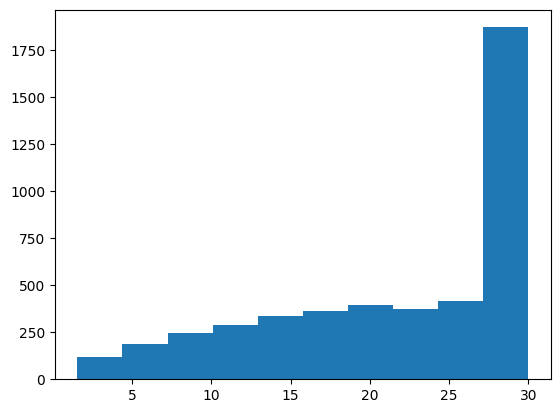

In [5]:
import pylab as plt
plt.hist(df['duration'])

In [6]:

df = df.assign(speaker_id=None)
df = df.assign(gender=None)

g_test = pd.read_csv(f'{base_dir}test.tsv', header=None, sep='\t', names=['audio', 'text'])
g_valid = pd.read_csv(f'{base_dir}dev.tsv', header=None, sep='\t', names=['audio', 'text'])

g_test['audio'] = g_test['audio'].apply(lambda x: str(x).strip() + '.wav')
g_valid['audio'] = g_valid['audio'].apply(lambda x: str(x).strip() + '.wav')
g_test['audio'] = clips + g_test['audio']
g_valid['audio'] = clips + g_valid['audio']

print(g_test.head(2)['audio'].to_list())

g_test = g_test.reset_index(drop=True)
g_valid = g_valid.reset_index(drop=True)

g_test['duration'] = g_test['audio'].apply(lambda x: AudioSegment.from_file(x).duration_seconds)
g_valid['duration'] = g_valid['audio'].apply(lambda x: AudioSegment.from_file(x).duration_seconds)

# add two new columns i.e speaker_id and gender
g_test = g_test.assign(speaker_id=None)
g_test = g_test.assign(gender=None)
g_valid = g_valid.assign(speaker_id=None)
g_valid = g_valid.assign(gender=None)


from datasets import DatasetDict, Dataset, Audio

ds = DatasetDict({'train': Dataset.from_pandas(df.reset_index(drop=True)), 'test': Dataset.from_pandas(g_test), 'valid': Dataset.from_pandas(g_valid)})

ds = ds.cast_column('audio', Audio(sampling_rate = 16000))

print(ds)
print(ds['train'][0])
print(ds['valid'][0])




['/mnt/data/Speech Dataset/GoogleSynth/Google-synth/clips/45001.wav', '/mnt/data/Speech Dataset/GoogleSynth/Google-synth/clips/45002.wav']
DatasetDict({
    train: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 4589
    })
    test: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['audio', 'text', 'duration', 'speaker_id', 'gender'],
        num_rows: 4999
    })
})
{'audio': {'path': '/mnt/data/Speech Dataset/GoogleSynth/Google-synth/expanded_clips/13.wav.wav', 'array': array([ 0.00068803, -0.00057511, -0.00119219, ...,  0.        ,
        0.        ,  0.        ]), 'sampling_rate': 16000}, 'text': 'ਨਾ ਹੀ ਸੌਂ ਸਕਦਾ ਸ਼ਮਸ਼ੇਰ ਸਿੰਘ ਸੰਧੂ ਧੋਖੇਬਾਜ਼ ਅਦਾਵਾਂ ਮੈਨੂੰ ਛੱਡ ਅਵੋ ਹੌਲੀ ਹੱਸਿਆ ਕਰ ਤੂੰ ਠੀਕ ਸਮਝਿਐਂ ਛਡੇ ਪੰਜ ਜੈਕਾਰੇ ਕੁੱਝ ਗਲਤਫਹਿਮੀਆਂ ਗੁਰੂ ਅਮਰਦਾਸ ਜੀ ਡਾ ਹਰਸ਼ਿੰਦਰ ਕੌਰ ਕੁੱਝ ਖ਼ਾਸ ਫਾਇਦੇ ਜਾਣਿਆ ਜਾਂਦਾ ਹੈ', 'duration': 16.05, 'speaker_id': None, 'gender': No

In [8]:
ds.save_to_disk('/mnt/data/Speech Dataset/processed_datasets/Google_Synth_ASR/', num_proc=24)

Saving the dataset (0/24 shards):   0%|          | 0/4589 [00:00<?, ? examples/s]

Saving the dataset (0/24 shards):   0%|          | 0/5000 [00:00<?, ? examples/s]

Saving the dataset (0/24 shards):   0%|          | 0/4999 [00:00<?, ? examples/s]